## Imports

In [1]:
%config IPCompleter.greedy=True
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import sys
import os
from PIL import Image
from cache import cache

c:\pphiles\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\pphiles\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\pphiles\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\pphiles\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (type, 1) or '1ty

In [2]:
# from tf.keras.models import Model
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Input, Dense, GRU, Embedding
from tensorflow.python.keras.applications import VGG16
from tensorflow.python.keras.optimizers import RMSprop
from tensorflow.python.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences

In [3]:
tf.__version__

'1.14.0'

In [4]:
tf.keras.__version__

'2.2.4-tf'

## Load Data

http://cocodataset.org

In [5]:
import coco

In [6]:
coco.set_data_dir("D:\data\coco")

Automatically download and extract the data-files

training-data 19 GB and validation-data is 816 MB

In [7]:
coco.maybe_download_and_extract()

Data has apparently already been downloaded and unpacked.
Data has apparently already been downloaded and unpacked.
Data has apparently already been downloaded and unpacked.


Get the filenames and captions for the images in the training-set.

In [8]:
_, filenames_train, captions_train = coco.load_records(train=True)

- Data loaded from cache-file: D:\data\coco\records_train.pkl


Number of images in the training-set.

In [9]:
num_images_train = len(filenames_train)
num_images_train

118287

Get the filenames and captions for the images in the validation-set.

In [10]:
_, filenames_val, captions_val = coco.load_records(train=False)

- Data loaded from cache-file: D:\data\coco\records_val.pkl


### Helper-Functions

helper-function for loading and resizing an image.

In [11]:
def load_image(path, size=None):
    """
    Load the image from the given file-path and resize it
    to the given size if not None.
    """

    # Load the image using PIL.
    img = Image.open(path)

    # Resize image if desired.
    if not size is None:
        img = img.resize(size=size, resample=Image.LANCZOS)

    # Convert image to numpy array.
    img = np.array(img)

    # Scale image-pixels so they fall between 0.0 and 1.0
    img = img / 255.0

    # Convert 2-dim gray-scale array to 3-dim RGB array.
    if (len(img.shape) == 2):
        img = np.repeat(img[:, :, np.newaxis], 3, axis=2)

    return img

In [12]:
def show_image(idx, train):
    """
    Load and plot an image from the training- or validation-set
    with the given index.
    """

    if train:
        # Use an image from the training-set.
        dir = coco.train_dir
        filename = filenames_train[idx]
        captions = captions_train[idx]
    else:
        # Use an image from the validation-set.
        dir = coco.val_dir
        filename = filenames_val[idx]
        captions = captions_val[idx]

    # Path for the image-file.
    path = os.path.join(dir, filename)

    # Print the captions for this image.
    for caption in captions:
        print(caption)
    
    # Load the image and plot it.
    img = load_image(path)
    plt.imshow(img)
    plt.show()

A giraffe eating food from the top of the tree.
A giraffe standing up nearby a tree 
A giraffe mother with its baby in the forest.
Two giraffes standing in a tree filled area.
A giraffe standing next to a forest filled with trees.


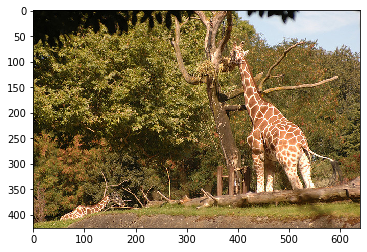

In [13]:
show_image(idx=1, train=True)

## Image Model (VGG16)


In [14]:
image_model = VGG16(include_top=True, weights='imagenet')

W1107 15:45:09.634166  6212 deprecation.py:506] From c:\pphiles\python37\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [15]:
image_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

Transfer from the layer prior to the final classification-layer `fc2`. 

In [16]:
transfer_layer = image_model.get_layer('fc2')

Transfer model with the same input as VGG16 but outputs the transfer-values from the `fc2` layer.

In [17]:
image_model_transfer = Model(inputs=image_model.input,
                             outputs=transfer_layer.output)

Input images size:

In [18]:
img_size = K.int_shape(image_model.input)[1:3]
img_size

(224, 224)

Output shape of the transfer model

In [19]:
transfer_values_size = K.int_shape(transfer_layer.output)[1]
transfer_values_size

4096

### Process All Images

Get transfer values of the images

In [20]:
def print_progress(count, max_count):
    pct_complete = count / max_count

    msg = "\r- Progress: {0:.1%}".format(pct_complete)

    # Print it.
    sys.stdout.write(msg)
    sys.stdout.flush()

In [21]:
def process_images(data_dir, filenames, batch_size=32):
    num_images = len(filenames)

    shape = (batch_size,) + img_size + (3,)
    image_batch = np.zeros(shape=shape, dtype=np.float16)

    shape = (num_images, transfer_values_size)
    transfer_values = np.zeros(shape=shape, dtype=np.float16)

    start_index = 0

    while start_index < num_images:
        print_progress(count=start_index, max_count=num_images)

        end_index = start_index + batch_size

        if end_index > num_images:
            end_index = num_images

        current_batch_size = end_index - start_index

        for i, filename in enumerate(filenames[start_index:end_index]):
            path = os.path.join(data_dir, filename)

            img = load_image(path, size=img_size)

            image_batch[i] = img

        transfer_values_batch = \
            image_model_transfer.predict(image_batch[0:current_batch_size])

        transfer_values[start_index:end_index] = \
            transfer_values_batch[0:current_batch_size]

        start_index = end_index

    print()

    return transfer_values

In [22]:
def process_images_train():
    print("Processing {0} images in training-set ...".format(len(filenames_train)))

    # Path for the cache-file.
    cache_path = os.path.join(coco.data_dir,
                              "transfer_values_train.pkl")

    # If the cache-file already exists then reload it,
    # otherwise process all images and save their transfer-values
    # to the cache-file so it can be reloaded quickly.
    transfer_values = cache(cache_path=cache_path,
                            fn=process_images,
                            data_dir=coco.train_dir,
                            filenames=filenames_train)

    return transfer_values

In [23]:
def process_images_val():
    print("Processing {0} images in validation-set ...".format(len(filenames_val)))

    # Path for the cache-file.
    cache_path = os.path.join(coco.data_dir, "transfer_values_val.pkl")

    # If the cache-file already exists then reload it,
    # otherwise process all images and save their transfer-values
    # to the cache-file so it can be reloaded quickly.
    transfer_values = cache(cache_path=cache_path,
                            fn=process_images,
                            data_dir=coco.val_dir,
                            filenames=filenames_val)

    return transfer_values

Process all images in the training-set and save the transfer-values to a cache-file. This took about 30 minutes to process on a GTX 1070 GPU.

In [24]:
%%time
transfer_values_train = process_images_train()
print("dtype:", transfer_values_train.dtype)
print("shape:", transfer_values_train.shape)

Processing 118287 images in training-set ...
- Data loaded from cache-file: D:\data\coco\transfer_values_train.pkl
dtype: float16
shape: (118287, 4096)
Wall time: 14.5 s


Process all images in the validation-set and save the transfer-values to a cache-file. This took about 90 seconds to process on a GTX 1070 GPU.

In [25]:
%%time
transfer_values_val = process_images_val()
print("dtype:", transfer_values_val.dtype)
print("shape:", transfer_values_val.shape)

Processing 5000 images in validation-set ...
- Data loaded from cache-file: D:\data\coco\transfer_values_val.pkl
dtype: float16
shape: (5000, 4096)
Wall time: 829 ms


## SVO Extractor

Using the NLTK framework to get the `<subject, verb, object>` from the NLP Tree

The CoreNLP server needs to be running on the default port `9000`

Add `nltk.data.path` in `svo.py`

`java -mx6g -cp "*" edu.stanford.nlp.pipeline.StanfordCoreNLPServer -timeout 5000`

In [26]:
from svo import SVO

svo = SVO()

def get_triplet(sentence):
    val = []
    root_tree = svo.get_parse_tree(sentence)
    treezo = svo.get_parse_tree(sentence)
    val.append(svo.process_parse_tree(next(root_tree)))
    #print(val)
    #print(len(val[0]))
    # return val[0][0]['subject'], val[0][0]['predicate'], val[0][0]['object'] if (len(val[0]) <= 1) else [[]]
    if (len(val[0]) >= 1): 
        return val[0][0]['subject'], val[0][0]['predicate'], val[0][0]['object'] 
    else: 
        return [[]]



In [27]:
def annotations_to_svo_triplets(annotations, trimmed = False):
    triplets = []
    for annotation in annotations:
        triplet = get_triplet(annotation)
        #print(f"Tri = {type(triplet)}")
        if len(triplet) > 1 or not trimmed:
            triplets.append(triplet)
    return triplets

In [28]:
def triplets_sentences(triplets):
    sentences = []
    for tri in triplets:
        sent = ""
        if type(tri) is tuple: 
            sent = " ".join((str(t[0]) for t in tri))
        sentences.append(sent)
    return sentences

Test

In [30]:
print(get_triplet("A giraffe eating food from the top of the tree."))

(['giraffe'], ['eating'], ['food'])


In [31]:
captions_train[1]

['A giraffe eating food from the top of the tree.',
 'A giraffe standing up nearby a tree ',
 'A giraffe mother with its baby in the forest.',
 'Two giraffes standing in a tree filled area.',
 'A giraffe standing next to a forest filled with trees.']

In [32]:
annotations_to_svo_triplets(captions_train[1], trimmed=False)

[(['giraffe'], ['eating'], ['food']),
 (['giraffe'], ['standing'], ['tree']),
 [[]],
 (['giraffes'], ['filled'], ['tree']),
 [[]]]

In [33]:
triplets_sentences(annotations_to_svo_triplets(captions_train[1], trimmed=False))

['giraffe eating food',
 'giraffe standing tree',
 '',
 'giraffes filled tree',
 '']

## Process all captions

In [34]:
import sys, os, os.path
def triple_captions(captions_list):
    sys.stdout = open(os.devnull, 'w')
    captions_marked = [triplets_sentences(annotations_to_svo_triplets(caption, trimmed=False))
                        for caption in captions_list]
    sys.stdout = sys.__stdout__
    
    return captions_marked

In [35]:
%%time
import pickle
triplet_list_file = "triplet_list_v1.pkl"
if os.path.exists(triplet_list_file): 
    with open(triplet_list_file, 'rb') as f:
        raw = f.read()
    captions_train_triple = pickle.loads(raw)
else: 
    with open(triplet_list_file, 'wb') as f:
        captions_train_triple = triple_captions(captions_train)
        pickle.dump(captions_train_triple, f)
captions_train_triple[11]

Wall time: 212 ms


['motorcycle parked parking',
 'motorcycle parked motorcycles',
 'Motorcycle parked parking',
 '',
 '']

Remove empty text

In [36]:
captions_train_triple_F = [list(filter(None, lst)) for lst in captions_train_triple]

In [37]:
captions_train_triple_F[11]

['motorcycle parked parking',
 'motorcycle parked motorcycles',
 'Motorcycle parked parking']

In [38]:
len(captions_train)

118287

In [39]:
len(captions_train_triple_F)

118287

## Tokenize the data

In [41]:
mark_start = 'ssss '
mark_end = ' eeee'

In [42]:
def mark_captions(captions_listlist):
    captions_marked = [[mark_start + caption + mark_end
                        for caption in captions_list]
                        for captions_list in captions_listlist]
    
    return captions_marked

In [43]:
captions_train_marked = mark_captions(captions_train_triple_F)
captions_train_marked[0]

['ssss dishes holding vegetables eeee']

In [44]:
captions_train[0]

['Closeup of bins of food that include broccoli and bread.',
 'A meal is presented in brightly colored plastic trays.',
 'there are containers filled with different kinds of foods',
 'Colorful dishes holding meat, vegetables, fruit, and bread.',
 'A bunch of trays that have different food.']

This helper-function converts a list-of-list to a flattened list of captions.

In [45]:
def flatten(captions_listlist):
    captions_list = [caption
                     for captions_list in captions_listlist
                     for caption in captions_list]
    
    return captions_list

Now use the function to convert all the marked captions from the training set.

In [46]:
captions_train_flat = flatten(captions_train_marked)

In [47]:
from collections import Counter
captions_train_flat[2]

'ssss giraffe standing tree eeee'

Set the maximum number of words in our vocabulary. This means that we will only use e.g. the 10000 most frequent words in the captions from the training-data.

In [48]:
num_words = 10000

In [49]:
class TokenizerWrap(Tokenizer):
    
    def __init__(self, texts, num_words=None):

        Tokenizer.__init__(self, num_words=num_words)

        self.fit_on_texts(texts)

        self.index_to_word = dict(zip(self.word_index.values(),
                                      self.word_index.keys()))

    def token_to_word(self, token):

        word = " " if token == 0 else self.index_to_word[token]
        return word 

    def tokens_to_string(self, tokens):
        words = [self.index_to_word[token]
                 for token in tokens
                 if token != 0]
        
        text = " ".join(words)

        return text
    
    def captions_to_tokens(self, captions_listlist):
        tokens = [self.texts_to_sequences(captions_list)
                  for captions_list in captions_listlist]
        
        return tokens

In [50]:
%%time
tokenizer = TokenizerWrap(texts=captions_train_flat,
                          num_words=num_words)

Wall time: 2.94 s


In [51]:
token_start = tokenizer.word_index[mark_start.strip()]
token_start

1

In [52]:
token_end = tokenizer.word_index[mark_end.strip()]
token_end

2

In [53]:
%%time
tokens_train = tokenizer.captions_to_tokens(captions_train_marked)

Wall time: 3.04 s


In [54]:
tokens_train[0]

[[1, 693, 7, 320, 2]]

In [55]:
captions_train_marked[0]

['ssss dishes holding vegetables eeee']

### Clean up

In [56]:
len(tokens_train)

118287

In [57]:
empty_captions = []
for i in range(len(tokens_train)): 
    if len(tokens_train[i]) == 0: 
        empty_captions.append(i)
        
len(empty_captions)

11480

In [58]:
transfer_values_train = np.delete(transfer_values_train, empty_captions)
captions_train_marked = np.delete(captions_train_marked, empty_captions)
tokens_train = np.delete(tokens_train, empty_captions)
filenames_train = np.delete(filenames_train, empty_captions)
captions_train = np.delete(captions_train, empty_captions)

In [59]:
num_images_train = len(filenames_train)
num_images_train

106807

In [60]:
len(tokens_train)

106807

## Data Generator

This helper-function returns a list of random token-sequences for the images in the training-set.

In [55]:
def get_random_caption_tokens(idx):
    
    result = []

    for i in idx:

        j = np.random.choice(len(tokens_train[i]))

        tokens = tokens_train[i][j]

        result.append(tokens)

    return result

Create random batches of training-data.

In [56]:
def batch_generator(batch_size):

    # Infinite loop.
    while True:
        idx = np.random.randint(num_images_train,
                                size=batch_size)
        
        transfer_values = transfer_values_train[idx]

        tokens = get_random_caption_tokens(idx)

        num_tokens = [len(t) for t in tokens]
        
        max_tokens = np.max(num_tokens)
        
        tokens_padded = pad_sequences(tokens,
                                      maxlen=max_tokens,
                                      padding='post',
                                      truncating='post')
        
        decoder_input_data = tokens_padded[:, 0:-1]
        decoder_output_data = tokens_padded[:, 1:]

        x_data = \
        {
            'decoder_input': decoder_input_data,
            'transfer_values_input': transfer_values
        }

        y_data = \
        {
            'decoder_output': decoder_output_data
        }
        
        yield (x_data, y_data)

Set the batch-size. 

In [57]:
batch_size = 256

In [58]:
generator = batch_generator(batch_size=batch_size)

Test

In [59]:
batch = next(generator)
batch_x = batch[0]
batch_y = batch[1]

In [61]:
show_image(idx=31520, train=True)
captions_train_marked[31520]

['ssss giraffes observe area eeee']

Transfer values in the batch

In [62]:
batch_x['transfer_values_input'][0]

0.3806

Caption tokens input

In [63]:
batch_x['decoder_input'][0]

array([   1,    5, 2072,  579])

Caption tokens output

In [64]:
batch_y['decoder_output'][0]

array([   5, 2072,  579,    2])

### Steps Per Epoch

In [65]:
num_captions_train = [len(captions) for captions in captions_train]

Total number of captions in the training-set.

In [66]:
total_num_captions_train = np.sum(num_captions_train)

Number of batches per epoch.

In [67]:
steps_per_epoch = int(total_num_captions_train / batch_size)
steps_per_epoch

2087

## The Recurrent Neural Network

The decoder uses 3 GRU layers:

In [68]:
state_size = 512

In [69]:
embedding_size = 128

This inputs transfer-values to the decoder:

In [70]:
transfer_values_input = Input(shape=(transfer_values_size,),
                              name='transfer_values_input')

`tanh` activation function used to limit the output of the mapping between -1 and 1.

In [72]:
decoder_transfer_map = Dense(state_size,
                             activation='tanh',
                             name='decoder_transfer_map')

Token-sequences can have arbitrary lengths.

In [73]:
decoder_input = Input(shape=(None, ), name='decoder_input')

Embedding-layer converts sequences of integer-tokens to sequences of vectors.

In [74]:
decoder_embedding = Embedding(input_dim=num_words,
                              output_dim=embedding_size,
                              name='decoder_embedding')

W1102 20:35:42.943231 18648 deprecation.py:506] From c:\pphiles\python37\lib\site-packages\tensorflow\python\keras\initializers.py:119: calling RandomUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


3 GRU layers of the decoder.

In [75]:
decoder_gru1 = GRU(state_size, name='decoder_gru1',
                   return_sequences=True)
decoder_gru2 = GRU(state_size, name='decoder_gru2',
                   return_sequences=True)
decoder_gru3 = GRU(state_size, name='decoder_gru3',
                   return_sequences=True)

In [76]:
decoder_dense = Dense(num_words,
                      activation='linear',
                      name='decoder_output')

### Create the Training Model

In [77]:
def connect_decoder(transfer_values):
    initial_state = decoder_transfer_map(transfer_values)

    net = decoder_input
    
    net = decoder_embedding(net)
    
    net = decoder_gru1(net, initial_state=initial_state)
    net = decoder_gru2(net, initial_state=initial_state)
    net = decoder_gru3(net, initial_state=initial_state)

    decoder_output = decoder_dense(net)
    
    return decoder_output

In [78]:
decoder_output = connect_decoder(transfer_values=transfer_values_input)

decoder_model = Model(inputs=[transfer_values_input, decoder_input],
                      outputs=[decoder_output])

### Loss Function

In [79]:
# decoder_model.compile(optimizer=optimizer,
#                       loss='sparse_categorical_crossentropy')

In [80]:
def sparse_cross_entropy(y_true, y_pred):

    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y_true,
                                                          logits=y_pred)
    loss_mean = tf.reduce_mean(loss)

    return loss_mean

### Compile the Training Model

In [81]:
optimizer = RMSprop(lr=1e-3) # or Adam

In [82]:
decoder_target = tf.placeholder(dtype='int32', shape=(None, None))

In [83]:
decoder_model.compile(optimizer=optimizer,
                      loss=sparse_cross_entropy,
                      target_tensors=[decoder_target])

### Callback Functions

In [88]:
path_checkpoint = 'capT_checkpoint.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      verbose=1,
                                      save_weights_only=True)

In [89]:
callback_tensorboard = TensorBoard(log_dir='./capT_logs/',
                                   histogram_freq=0,
                                   write_graph=False)

In [90]:
callbacks = [callback_checkpoint, callback_tensorboard]

### Load Checkpoint

In [91]:
try:
    decoder_model.load_weights(path_checkpoint)
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)

Error trying to load checkpoint.
Unable to open file (unable to open file: name = 'capT_checkpoint.keras', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


### Train the Model

In [92]:
%%time
decoder_model.fit_generator(generator=generator,
                            steps_per_epoch=steps_per_epoch,
                            epochs=20,
                            callbacks=callbacks)

Epoch 1/20


ValueError: Error when checking input: expected transfer_values_input to have shape (4096,) but got array with shape (1,)

## Generate

In [78]:
def generate_caption(image_path, max_tokens=30):
    
    image = load_image(image_path, size=img_size)
    
    image_batch = np.expand_dims(image, axis=0)

    transfer_values = image_model_transfer.predict(image_batch)

    shape = (1, max_tokens)
    decoder_input_data = np.zeros(shape=shape, dtype=np.int)

    token_int = token_start

    output_text = ''

    count_tokens = 0

    while token_int != token_end and count_tokens < max_tokens:
        decoder_input_data[0, count_tokens] = token_int

        x_data = \
        {
            'transfer_values_input': transfer_values,
            'decoder_input': decoder_input_data
        }

        decoder_output = decoder_model.predict(x_data)

        token_onehot = decoder_output[0, count_tokens, :]

        token_int = np.argmax(token_onehot)

        sampled_word = tokenizer.token_to_word(token_int)

        output_text += " " + sampled_word

        count_tokens += 1

    output_tokens = decoder_input_data[0]

    plt.imshow(image)
    plt.show()
    
    print("Predicted caption:")
    print(output_text)
    print()

In [79]:
def generate_caption_coco(idx, train=False):
    
    if train:
        data_dir = coco.train_dir
        filename = filenames_train[idx]
        captions = captions_train[idx]
    else:
        data_dir = coco.val_dir
        filename = filenames_val[idx]
        captions = captions_val[idx]

    path = os.path.join(data_dir, filename)

    generate_caption(image_path=path)

    print("True captions:")
    for caption in captions:
        print(caption)


### Examples

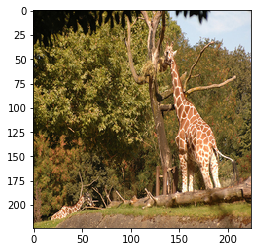

Predicted caption:
 a giraffe is standing in a field of grass eeee

True captions:
A giraffe eating food from the top of the tree.
A giraffe standing up nearby a tree 
A giraffe mother with its baby in the forest.
Two giraffes standing in a tree filled area.
A giraffe standing next to a forest filled with trees.


In [80]:
generate_caption_coco(idx=1, train=True)

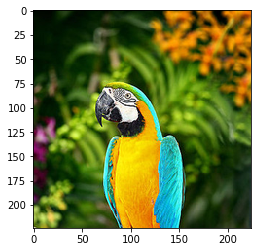

Predicted caption:
 a bird is sitting on a branch in a tree eeee



In [81]:
generate_caption("./images/parrot_cropped1.jpg")

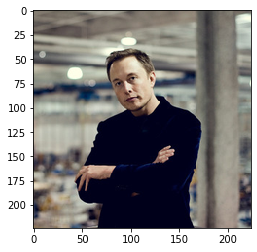

Predicted caption:
 a man in a suit and tie standing in front of a parking meter eeee



In [82]:
generate_caption("./images/elon_musk.jpg")

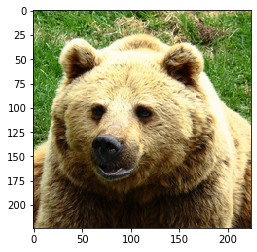

Predicted caption:
 a dog is playing with a frisbee in the grass eeee

True captions:
A big burly grizzly bear is show with grass in the background.
The large brown bear has a black nose.
Closeup of a brown bear sitting in a grassy area.
A large bear that is sitting on grass. 
A close up picture of a brown bear's face.


In [83]:
generate_caption_coco(idx=1, train=False)

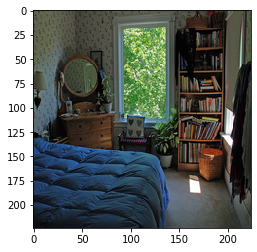

Predicted caption:
 a living room with a couch and a table eeee

True captions:
Bedroom scene with a bookcase, blue comforter and window.
A bedroom with a bookshelf full of books.
This room has a bed with blue sheets and a large bookcase
A bed and a mirror in a small room.
a bed room with a neatly made bed a window and a book shelf


In [84]:
generate_caption_coco(idx=2, train=False)